<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#DA-to-the-rescue:-EnKF" data-toc-modified-id="DA-to-the-rescue:-EnKF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DA to the rescue: EnKF</a></span></li><li><span><a href="#EnKF-for-WOFOST" data-toc-modified-id="EnKF-for-WOFOST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EnKF for WOFOST</a></span><ul class="toc-item"><li><span><a href="#The-experiment" data-toc-modified-id="The-experiment-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The experiment</a></span></li></ul></li></ul></div>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
import copy
import datetime as dt
import pcse
from pcse.models import Wofost71_WLP_FD
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


from wofost_da import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="float:right">
<table>
<tr>
    <td> <img src="figs/nceo_logo.png" alt="Drawing" style="width:200px;height:40px;"/> </td>
    <td> <img src="figs/gssti_logo.png" alt="Drawing" style="width:200px;height:40px;"/> </td>
    <td> <img src="figs/multiply_logo.png" alt="Drawing" style="width:40px;height:40px;"/> </td>
</tr>
    </table>
</div>

# Data assimilation with the WOFOST model: EnKF filter

**Author:** Jose Gómez-Dans (NCEO & UCL)  `j.gomez-dans@ucl.ac.uk`

## Introduction

So far, we've had a look at EO data of croplands, and we had a brief play with crop models. Although these topics are major research areas on their own right, it is possible to do a first sum up of what we've seen.

**EO data**
- Retrieving agronomically meaningful parameters from e.g. reflectance or radiance data is a complex task. A lot of assumptions go into this task. 
- Perhaps the most interesting parameter is LAI (and is closely related cousing, fAPAR). One reason for its popularity is that LAI is also a parameter used and/or predicted by mechanistic growth models and a major indicator of crop development
- Optical EO data is hampered by clouds, which can result in not much data being available (e.g. large data gaps in agronomically meaningful periods). Other properties of the sensor that affect the retrievals are its spatial resolution, its spectral properties
- There are other observables from space. These include thermal data (e.g. land surface temperature), passive microwaves (often used for soil moisture). SAR is also used for understanding both vegetation and soil properties. New measurements, such as SIF (solar induced fluorescence) are also becoming practical.
- A number of *products* that translate the "raw" EO signal into useful parameters have been developed. It makes sense to use them!
- ...but always remember to evaluate them to see how they perform. Also be aware that they make make assumptions that are incompatible with other bits of your processing!
- EO data only gives a partial window into crops: we infer LAI, maybe soil moisture, but we are interested in biomass or grain yield!

**Crop models**
- There are many crop models available. We can go from statistical models (that e.g. link anomalies in temperature, precipitation and a vegetation index and yield), to production efficiency models to more complex mechanistic models.
- PEM are fun to play around with, but are critically dependent on calibration and having sufficient EO data.
- Mechanistic models tend to be preferred, as they encompass a lot of our understanding of crop physiology, soil hydraulics. When we refer to crop models, we'll refer to this type of crop models.
- Generally speaking, a crop model takes meteorology, soil and crop type/cultivar parameterisations and calculates the evolution of a crop.
- All this requires defining many processes, their interfaces and the parameters that govern such processes and how they are affected by meteorology, soil properties, management decisions, etc.
- Calibration of models to local conditions is critical
- However, the vast variation of farming practices, local microclimate and soil properties, as well as the many shortcomings of models themselves, of driver data and soil maps, often result in a model is that "approximately OK" for some area, but completely wrong for any individual field!

DA aims to merge these two independent views of the world, acknowledging the limitations of each. So if we have frequent observations of LAI over a field, how can we inform our crop model of that evidence, in a way that acknowledges the fact that LAI measurements may be uncertain, and that the model is also a bit ropey?

## DA to the rescue: EnKF

You've already encountered the EnKF. To introduce a common mathematical notation, let $y$ be our observations of e.g. LAI and/or soil moisture. Let our state vector be the stacking of state parameters of the crop model (e.g. LAI, SM, TAGP, DVS, ...). We will assume that our observations are corrupted by zero mean Gaussian noise with some uncertainty, and that we can encode the uncertainty in our state by using a multivariate Gaussian. If we call our state mean vector at a given timestep $\mu$ and its associated covariance matrix $\mathbf{P}$, then we can draw a number of realisations of the state using a random number generator. Each of these can be propagated by the crop model (run possibly sampling different soil properties, or sampling maybe uncertainties in meteorological drivers or crop parameters), to provide a population of states after some time. We can then *assimilate* the LAI observations to refine our guess of the state at that point, and go back to running the crop model.

<img src="http://robertsy.github.io/ensemble-da/assets/img/EnKF.png" width="400px" />


## EnKF for WOFOST

### The experiment

Rather than using real data (who needs that, amirite!!!?), we will use a synthetic WOFOST run from where we will derive some observations. This synthetic experiment allows us to compare the result of assimilating the data to the "truth", and also allows us to check the effect of the imperfections in the observations.

We will consider observations of LAI and SM. As a start, we will define an *ensemble* of models where each member will be run with different parameters and initial conditions. In effect, the ensemble will be made up of our uncertainty in the initial state of the system, as well as the uncertainty in the model parameters. Other factors we could have included would be different meteorology to account for meteo uncertainty. This basically means that each ensemble will run forward in a different way, but the ensemble should capture the typical variability of the crop trajectories we want to observe. This again underlines the necessity of having a relisitic, uncertainty-quantified clibration of the model: DA cannot make miracles!

In essence, each of these members will be run forward until an observation is found. At that point, since both LAI and SM are in the observations and in the model, the standard Kalman update formula for the identity observation operator will be used to update the LAI and/or SM value at that timestep of every ensemble member, which will then be run forward using WOFOST, until a new observation is available.




In [17]:
results, observations = run_ensemble(10, assim_lai=False)

/home/ucfajlg/.local/lib/python3.6/site-packages/pcse/fileinput/yaml_agro_loader.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  r = yaml.load(fp)


> /home/ucfajlg/python/accra_wkshp/wofost_da.py(167)run_filter()
-> results = [pd.DataFrame(member.get_output()).set_index("day")
(Pdb) c


[[<matplotlib.lines.Line2D at 0x7f3295c253c8>],

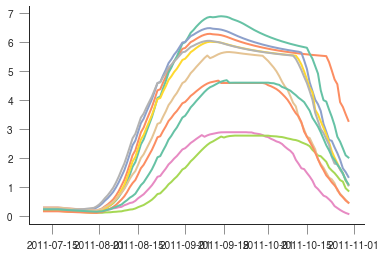

In [18]:
[plt.plot(r.LAI) for r in results]

tuple